In [1]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2


# This is needed to add the repo dir to the path so jupyter
# can load the republic modules directly from the notebooks
import os
import sys
repo_name = 'republic-project'
repo_dir = os.path.split(os.getcwd())[0].split(repo_name)[0] + repo_name
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)



/Users/marijnkoolen/Code/Huygens/republic-project


In [2]:
from republic.elastic.republic_elasticsearch import initialize_es
from republic.config.republic_config import set_config_inventory_num

rep_es = initialize_es(host_type="external")

inv_num = 3793
inv_config = set_config_inventory_num(inv_num, ocr_type="pagexml")



## Resolution Types

In [3]:
from collections import defaultdict

query = {
    'query': {
        'bool': {
            'should': [
                {'match': {'phrase.keyword': 'IS ter Vergaderinge gelesen de Requeste van '}},
                #{'match': {'phrase.keyword': 'OP de Requeste van '}}
            ]
        }
    },
    'aggs': {
        'strings': {
            'terms': {
                'field': 'string.keyword',
                'missing': 'N/A',
                'size': 5000
            }
        }
    },
    'size': 0,
    'track_total_hits': True
}



response = rep_es.es_anno.search(index='phrase_matches', body=query)

other = 0
num_other = 0
total = response['hits']['total']['value']
buckets = response['aggregations']['strings']['buckets']
lower_counts = defaultdict(int)
for bucket in buckets:
    lower_phrase = bucket['key']#.lower()
    lower_counts[lower_phrase] += bucket['doc_count']
print('number of OCR variants:', len(lower_counts.keys()))
    
print(f'{"total": <20}{total: >8}\t{total / total: >.2f}')
print('------------------------------------')
for lower_phrase, count in sorted(lower_counts.items(), key=lambda x: x[1], reverse=True):
    if lower_counts[lower_phrase] / total < 0.02:
        #print('add to other:', bucket)
        other += lower_counts[lower_phrase]
        num_other += 1
        continue
    print(f'{lower_phrase: <50} & {lower_counts[lower_phrase]: >8} & {lower_counts[lower_phrase] / total: >.2f} \\\\')
    
other_string = f"{num_other} other variations"
print(f'{other_string: <50} & {other: >8} & {other / total: >.2f} \\\\')


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/4142153259.py:27: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = rep_es.es_anno.search(index='phrase_matches', body=query)


number of OCR variants: 3651
total                  61510	1.00
------------------------------------
IS ter Vergaderinge geleesen de Requeste van       &    14157 & 0.23 \\
IS ter Vergaderinge gelesen de Requeste van        &    11303 & 0.18 \\
Is ter Vergaderinge gelesen de Requeste van        &     6312 & 0.10 \\
IS ter Vergaderinge geleezen de Requeste van       &     2956 & 0.05 \\
ls ter Vergaderinge gelesen de Requeste van        &     2583 & 0.04 \\
15 ter Vergaderinge gelesen de Requeste van        &     1336 & 0.02 \\
18 ter Vergaderinge geleesen de Requeste van       &     1326 & 0.02 \\
3644 other variations                              &    21537 & 0.35 \\


In [7]:
aggs = {
    'prop_types': {
        'terms': {
            'field': 'metadata.proposition_type.keyword',
            'missing': 'N/A',
            'size': 50
        }
    }
}
    
query = {
    'bool': {
        'must': [
            {
                'range': {
                    'metadata.session_year': {
                        'gte': 1705
                    }
                }
            }
        ]
    }
}

response = rep_es.es_anno.search(index='resolution_metadata', query=query, aggs=aggs, size=0, track_total_hits=True)
response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)

other = 0
total = response['hits']['total']['value']
buckets = response['aggregations']['prop_types']['buckets']
print(f'{"total": <20}{total: >8}\t{total / total: >.2f}')
print('------------------------------------')
for bi, bucket in enumerate(buckets):
    if bucket["doc_count"] / total < 0.01:
        #print('add to other:', bucket)
        other += bucket["doc_count"]
    print(f'{bi} {bucket["key"]: <20}{bucket["doc_count"]: >8}\t{bucket["doc_count"] / total: >.2f}')
    
print(f'{"other": <20}{other: >8}\t{other / total: >.2f}')


total                 312849	1.00
------------------------------------
0 missive               161346	0.52
1 requeste               77011	0.25
2 N/A                    25498	0.08
3 rapport                13144	0.04
4 onbekend               10224	0.03
5 memorie                 9427	0.03
6 oraal                   5168	0.02
7 voordracht              3261	0.01
8 resolutie               2556	0.01
9 conclusie               1736	0.01
10 declaratie              1345	0.00
11 advies                  1066	0.00
12 rekening                 715	0.00
13 instructie               277	0.00
14 paspoort                  75	0.00
other                   7770	0.02


In [8]:
other = 0
print(f'\t\t{"total": <10} \t& {total: >8} \t& ({int(100*total / total)}\\%) \\\\')
print('\t\t\\midrule')
for bucket in buckets:
    if bucket["doc_count"] / total < 0.01:
        other += bucket["doc_count"]
    print(f'\t\t{bucket["key"]: <10} \t& {bucket["doc_count"]: >8} \t& ({int(100 * bucket["doc_count"] / total)}\\%) \\\\')
    
print(f'\t\t{"other": <10} \t&{other: >8} \t& ({int(100*other / total)}\\%) \\\\')


		total      	&   312849 	& (100\%) \\
		\midrule
		missive    	&   161346 	& (51\%) \\
		requeste   	&    77011 	& (24\%) \\
		N/A        	&    25498 	& (8\%) \\
		rapport    	&    13144 	& (4\%) \\
		onbekend   	&    10224 	& (3\%) \\
		memorie    	&     9427 	& (3\%) \\
		oraal      	&     5168 	& (1\%) \\
		voordracht 	&     3261 	& (1\%) \\
		resolutie  	&     2556 	& (0\%) \\
		conclusie  	&     1736 	& (0\%) \\
		declaratie 	&     1345 	& (0\%) \\
		advies     	&     1066 	& (0\%) \\
		rekening   	&      715 	& (0\%) \\
		instructie 	&      277 	& (0\%) \\
		paspoort   	&       75 	& (0\%) \\
		other      	&    7770 	& (2\%) \\


In [15]:
# What are those resolutions with missing proposition types?

query = {
    'query': {
        'bool': {
            'must_not': [
                {'exists': {'field': 'metadata.proposition_type'}}
            ]
        }
    }
}

response = es_republic.search(index='resolution_metadata', body=query)

for hit in response['hits']['hits']:
    doc = hit['_source']
    res_id = doc['metadata']['id'].replace('-metadata', '')
    resolution = rep_es.retrieve_resolution_by_id(es_republic, res_id, inv_config)
    print(resolution.paragraphs[0].text)


BY resumptie gedelibereert zynde op een Misfsive van den Resident van Til, geschreven te Lissabon den een en twintighsten September laatstleden, en ingekomen den twee en twintighsten October daar aanvolgende, waar by hy versoeckt permissie, om in het voorjaar een keer herwaardts te mogen doen, ten deele over zaacken van de Commercie, en ten deele tot verrichtingh van sijn particuliere affaires. IS goedtgevonden en verstaan, dat aan gemelden Resident van Til zal werden gerescribeert, dat hem mits desen gepermitteert wordt, om een keer herwaardts te doen, zoo verre het buyten ondienst van den Lande zal kunnen geschieden, mits gehouden blyvende, sigh te reguleeren na het negen en dertighste Articul van het Reglement.
De Heeren Gedeputeerden van de Provincie van Zeelandt, hebben ter Vergaderinge ingebraght ende laten lesen de Resolutie van de Heeren Staten van de hoogh-gemelde Provincie hare Principalen, raeckende feeckere dertigh Vaten Fransche Wyn te Sluys, door die van de vrye Compagnie

In [12]:
from republic.model.resolution_phrase_model import proposition_opening_phrases

def make_evidence_phrase_query(prop_type):
    return {
        'bool': {
            #'must_not': [
            #    {'exists': {'field': 'metadata.proposition_type'}},
            #],
            'must': [
                {'match': {'evidence.phrase.keyword': prop_type}}
            ]
        }
    }

prop_types = ['ONtfangen een Missive van']

for prop_type in prop_types:
    query = make_evidence_phrase_query(prop_type)
    response = rep_es.es_anno.search(index=inv_config['resolution_index'], query=query, 
                                     size=0, track_total_hits=True)
    print(response['hits']['total']['value'])
    docs = [hit['_source'] for hit in response['hits']['hits']]
    for doc in docs:
        print(doc['evidence'][0]['phrase'])

        

162894


In [14]:
query = {
    'bool': {
        'must': [
            {'match': {'metadata.proposition_type': 'requeste'}},
            {'match': {'metadata.formula.proposition_opening.text.keyword': 'OP de Requeste van '}}
        ]
    }
}

aggs = {
    'formulas': {
        'terms': {
            'field': 'metadata.formula.proposition_opening.text.keyword'
        }
    }
}

rep_es.es_anno.search(index='resolution_metadata', query=query, size=10, aggs=aggs)

{'took': 54,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 3.9825234,
  'hits': [{'_index': 'resolution_metadata',
    '_type': '_doc',
    '_id': 'session-1737-05-06-num-1-resolution-17-metadata',
    '_score': 3.9825234,
    '_source': {'metadata': {'inventory_num': 3792,
      'source_id': 'session-1737-05-06-num-1',
      'type': 'resolution',
      'id': 'session-1737-05-06-num-1-resolution-17-metadata',
      'session_date': '1737-05-06',
      'session_id': 'session-1737-05-06-num-1',
      'session_num': 1,
      'president': None,
      'session_year': 1737,
      'session_month': 5,
      'session_day': 6,
      'session_weekday': 'Lunae',
      'proposition_type': 'requeste',
      'proposer': {'variable_entity': {'text': 'Willem Smits,',
        'start_offset': 19,
        'end_offset': 32},
       'person_role': [{'text': 'Koopman',
         'start_offset': 3

## Analysing the extracted metadata

In [15]:
def make_query(prop_type):
    return {
        'query': {
            'bool': {
                'must': [
                    {'match': {'metadata.proposer.person_role': prop_type}}
                ]
            }
        },
        'size': 0,
        'track_total_hits': True
    }

def make_aggs_query(field: str, aggs_name: str = 'some_name', size: int = 50):
    field = field + '.keyword'
    return {
        aggs_name: {
            'terms': {
                'field': field,
                'missing': '<no_value>', 
                'size': size
            }
        }
    }


def show_field_value_aggregation(field, size: int = 500, query = None):
    aggs = make_aggs_query(field)
    print(query)
    if query:
        response = rep_es.es_anno.search(index=inv_config['resolution_metadata_index'], 
                                         aggs=aggs, query=query, size=size, track_total_hits=True)
    else:
        response = rep_es.es_anno.search(index=inv_config['resolution_metadata_index'], 
                                         aggs=aggs, size=size, track_total_hits=True)
    total = response['hits']['total']['value']
    print(f"{'Total': <40}{response['hits']['total']['value']: >7}\t{int(total * 100 / total): >6}")
    print('-----------------------------------------------')
    other_sum = 0
    other_len = 0
    for bi, bucket in enumerate(response['aggregations']['some_name']['buckets']):
        if bi >= size-1:
            other_sum += bucket['doc_count']
            other_len += 1
            continue
        print(f"{bucket['key']: <40}{bucket['doc_count']: >7}\t{int(bucket['doc_count'] * 100 / total): >6}")
    others = f"{other_len} others"
    print(f"{others: <40}{other_sum: >7}\t{int(other_sum * 100 / total): >6}")

In [16]:
field = 'metadata.proposer.person_role.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               105962	    38
extraordinaris                            33554	    12
Envoyé                                    32258	    11
den Koning van                            28604	    10
den Resident                              22423	     8
Minister                                  18970	     6
Gedeputeerde                              18008	     6
Plenipotentiaris                          15268	     5
Ambassadeur                               12500	     4
Regent                                     9976	     3
de Kinderen van                            9007	     3
Koopman                                    7044	     2
Scheepenen                                 5773	     2
Commissaris van                            5589	     2
Lieutenant                                 4616	     1
Kooplieden                                 4192	     1
den Commissa

In [17]:
field = 'metadata.proposer.person_role.text'
query = {
    "bool": {
        "must": [
            {"match": {"metadata.proposition_type": "missive"}}
        ]
    }
}
show_field_value_aggregation(field, query=query)

{'bool': {'must': [{'match': {'metadata.proposition_type': 'missive'}}]}}
Total                                    160816	   100
-----------------------------------------------
<no_value>                                59944	    37
extraordinaris                            28826	    17
Envoyé                                    28290	    17
den Koning van                            24430	    15
den Resident                              22082	    13
Minister                                  16986	    10
Plenipotentiaris                          13046	     8
Ambassadeur                               10844	     6
Commissaris van                            4645	     2
den Commissaris                            3563	     2
Gedeputeerde                               3260	     2
Scheepenen                                 2408	     1
sijne Hoogheid                             2190	     1
Burgemeester                               2124	     1
Lieutenant                                 1883	     

In [18]:
field = 'metadata.proposer.person_role.text'
query = {
    "bool": {
        "must": [
            {"match": {"metadata.proposition_type": "requeste"}}
        ]
    }
}
show_field_value_aggregation(field, query=query)

{'bool': {'must': [{'match': {'metadata.proposition_type': 'requeste'}}]}}
Total                                     75634	   100
-----------------------------------------------
<no_value>                                33055	    43
Regent                                     8618	    11
Koopman                                    6615	     8
Kooplieden                                 3781	     4
Weduwe                                     2953	     3
Scheepenen                                 2720	     3
Burger                                     2696	     3
Lieutenant                                 2509	     3
Suppliant                                  2110	     2
Schipper                                   2056	     2
Generaal Major                             1795	     2
Inwoonder                                  1610	     2
Burgemeester                               1418	     1
Leverancier                                1265	     1
extraordinaris                             1125	    

In [19]:
field = 'metadata.proposer.location.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               210039	    75
Groot Britannien                          10051	     3
Amsterdam                                  9209	     3
Londen                                     7812	     2
's Hertogenbosch                           6677	     2
Pruissen                                   6510	     2
Maastricht                                 4270	     1
Brussel                                    2664	     0
de Oostentycksche Nederlanden              2318	     0
Rotterdam                                  2138	     0
Keulen                                     1965	     0
Venlo                                      1878	     0
Stad en Lande                              1600	     0
Weenen                                     1498	     0
Leyden                                     1439	     0
Utrecht                                    1299	     0
Vranckrijk  

In [20]:
field = 'metadata.proposer.organisation.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               242678	    87
het Collegie ter Admiraliteit              9584	     3
Staaten van de Provincie                   5684	     2
de Heeren Staaten van de Provincie         4522	     1
by den Ryksdag                             4142	     1
en andere Raaden                           3981	     1
de Generaliteit                            2856	     1
de Meyerye                                 2104	     0
Raad der Stad                              1655	     0
den Raad van Staate                        1499	     0
Westindische Compagnie                     1155	     0
van den Hove                               1153	     0
De Heeren Gedeputeerden van de Provincie    752	     0
Oostindische Compagnie                      735	     0
Hoofdbanke                                  139	     0
de Generaliteits Reekenkamer                109	     0
den Eerst-pr

In [21]:
field = 'metadata.proposer.representation_relation.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               227510	    82
aan het Hof van                           46456	    16
den Koning van                             4371	     1
Comptoir van                                964	     0
den Grave van                               108	     0
Comptoir Generaal van                         9	     0
den Representant van                          8	     0
ter Vergaderinge praesideerende               5	     0
0 others                                      0	     0


In [22]:
field = 'metadata.proposer.variable_entity.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                                48989	    17
Gallieris,                                 5657	     2
Hop,                                       5275	     1
, geschreven aldaar                        3586	     1
Rumpf,                                     2656	     0
Sweeden,                                   2625	     0
Vrankryk,                                  2432	     0
Vranckryck,                                2366	     0
Spina,                                     2315	     0
Hamel Bruyninx,                            2290	     0
de Swart,                                  2224	     0
de Zee,                                    2134	     0
Bilderbeeck,                               2111	     0
Spagne,                                    1985	     0
ende                                       1928	     0
, geschreeven aldaar                       1791	     0
den Keyser, 

In [23]:
field = 'metadata.proposition_verb.proposition_verb.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
houdende                                 150916	    54
<no_value>                                42097	    15
houdende advertentie.                     26346	     9
versoekende                               23434	     8
hebbende                                  18648	     6
sendende                                   5540	     1
kennisse geevende                          3013	     1
presenteerende                             2435	     0
raakende                                   2001	     0
dienende                                    902	     0
raeckende                                   799	     0
op ordre en ten dienste van                 567	     0
berigtende                                  213	     0
aanneemende                                 156	     0
reclameerende                               105	     0
brengende                                    99	     0
appuyeerende

In [24]:
field = 'metadata.proposition_origin.correspondence_from.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               140297	    50
geschreeven te                           126057	    45
geschreeven alhier in Den Hage            10947	     3
0 others                                      0	     0


In [25]:
field = 'metadata.proposition_origin.residence_relation.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               267982	    96
woonende te                                7810	     2
woonende alhier in den Hage                1511	     0
0 others                                      0	     0


In [26]:
field = 'metadata.proposition_origin.temporal_reference.text'
show_field_value_aggregation(field)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               171755	    61
den 1 deeser loopende maand               69836	    25
den .. der voorleeden maand               32796	    11
den 1 Januari laatstleden                  3130	     1
0 others                                      0	     0


In [27]:
field = 'metadata.proposition_origin.variable_entity.text'
show_field_value_aggregation(field, size=100)

None
Total                                    277301	   100
-----------------------------------------------
<no_value>                               178279	    64
Fagel,                                    23508	     8
Fagel ,                                    2890	     1
deeser loopende maand,                     1081	     0
den eersten deeser loopende maand,          983	     0
den derden deeser loopende maand,           914	     0
den seevenden deeser loopende maand,        834	     0
den neegenden deeser loopende maand,        806	     0
Elseneur                                    769	     0
den dertighsten der voorleede maand,        702	     0
den eersten                                 677	     0
den vyftienden deeser loopende maand,       665	     0
deser loopende maandt,                      650	     0
den aghtienden deeser loopende maand,       636	     0
Hermitage,                                  588	     0
den aghtsten deeser loopende maand,         577	     0
den eersten 

## Analysing Requests

In [28]:
from collections import defaultdict
import json
import copy


def element_dict_to_list(prop_dict):
    elements = []
    for field in prop_dict:
        if isinstance(prop_dict[field], list):
            for element in prop_dict[field]:
                element_copy = copy.deepcopy(element)
                element_copy['type'] = field
                elements.append(element_copy)
        else:
            element = prop_dict[field]
            element_copy = copy.deepcopy(element)
            element_copy['type'] = field
            elements.append(element_copy)
    return elements


def sort_elements_by_offset(prop_origin):
    elements = element_dict_to_list(prop_origin)
    elements.sort(key=lambda x: x['start_offset'])
    return elements


query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'metadata.proposition_type.keyword': 'requeste'}}
            ]
        }
    },
    'size': 1000
}

metadata_index = 'resolution_metadata'

other_fields = {
    'inventory_num', 'source_id', 'type', 'id', 
    'session_date', 'session_id', 'session_num', 'president', 
    'session_year', 'session_month', 'session_day', 'session_weekday',
    'decision', 'resolution_type', 'index_timestamp', 
}

proposition_fields = {
    'formula', 'proposition_origin', 'proposition_verb',
    'proposition_type', 'proposer', 
}


response = rep_es.es_anno.search(index=metadata_index, body=query)
resolutions = [hit['_source'] for hit in response['hits']['hits']]


metadata = defaultdict(list)

for resolution in resolutions:
    if 'proposition_origin' not in resolution['metadata']:
        continue
    formula = resolution['metadata']['formula']['proposition_opening']
    prop_org = resolution['metadata']['proposition_origin']
    elements = element_dict_to_list(prop_org)
    elements.sort(key=lambda x: x['start_offset'])
    print(resolution['metadata']['id'])
    print(f"\t{'formula': <20}{formula['start_offset']: >4} {formula['end_offset']: >4}\t{formula['text']}")
    for element in elements:
        if element['type'] == 'full_string':
            continue
        print(f"\t{element['type']: <20}{element['start_offset']: >4} {element['end_offset']: >4}\t{element['text']}")
        #print('\t', , element['text'])
    print()
    print(resolution['metadata']['proposition_verb'])
    print()
    
#for key in metadata:
#    print(key, metadata[key])

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/3606801584.py:54: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = rep_es.es_anno.search(index=metadata_index, body=query)


session-1737-05-06-num-1-resolution-17-metadata
	formula                0   19	OP de Requeste van 
	residence_relation    57   84	woonende alhier in den Hage
	person_location       66   84	alhier te den Hage



KeyError: 'proposition_verb'

In [126]:
from republic.extraction.extract_resolution_metadata import generate_proposition_searchers, add_resolution_metadata
from republic.model.republic_document_model import json_to_republic_resolution


proposition_searcher, template_searcher, variable_matcher = generate_proposition_searchers()
skip_formulas = {
    'heeft aan haar Hoog Mog. voorgedragen',
    'heeft ter Vergadering gecommuniceert ',
    'ZYnde ter Vergaderinge geëxhibeert vier Pasporten van',
    'hebben ter Vergaderinge ingebraght',
    'hebben ter Vergaderinge voorgedragen'
}

response = es_republic.get(index='resolutions', id='session-1735-12-29-num-1-resolution-7')
resolution = json_to_republic_resolution(response['_source'])

res = add_resolution_metadata(resolution, proposition_searcher, template_searcher, variable_matcher)

proposition_opening
0 IS ter Vergaderinge gelesen de Requeste van 
variable_entity
44 Zeger van Dijcke ,
variable_entity
75 Domburgh in Walcheren, Frungois vun Dijcke,
residence_relation
63 woonende tot
120 woonende tot
location
133 Middelburgh
variable_entity
144 in Zeelandt, Anthonius de Puit , als in huwelijk
proposition_verb
194 hebbende
[{'group_label': 'formula', 'element_label': 'proposition_opening', 'phrase': 'IS ter Vergaderinge gelesen de Requeste van ', 'evidence': {'type': 'PhraseMatch', 'phrase': 'IS ter Vergaderinge gelesen de Requeste van ', 'variant': 'IS ter Vergaderinge gelesen de Requeste van ', 'string': 'IS ter Vergaderinge gelesen de Requeste van ', 'offset': 0, 'label': ['proposition_opening', 'proposition_type:requeste'], 'text_id': 'session-1735-12-29-num-1-para-9', 'match_scores': {'char_match': 1.0, 'ngram_match': 1.0, 'levenshtein_similarity': 1.0}}, 'start_offset': 0, 'end_offset': 44}, {'element_label': 'full_string', 'phrase': 'IS ter Vergaderinge gelese

In [78]:
def make_aggs():
    return {
        'aggs': {
            'prop_type': {
                'terms': {
                    'field': 'metadata.proposition_type.keyword',
                    'size': 20
                }
            },
            'years': {
                'terms': {
                    'field': 'metadata.session_year',
                    'size': 100
                }
            },
            'months': {
                'terms': {
                    'field': 'metadata.session_month',
                    'size': 12
                }
            },
            'weekdays': {
                'terms': {
                    'field': 'metadata.session_weekday.keyword',
                }
            }
        }
    }


def make_prop_type_query(prop_type):
    return {
        'query': {
            'bool': {
                'must': [
                    {'match': {'metadata.proposition_type.keyword': prop_type}}
                ]
            }
        },
        'size': 0,
        'track_total_hits': True
    }




/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/2994003110.py:4: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  resolution_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


(0.0, 7000.0)

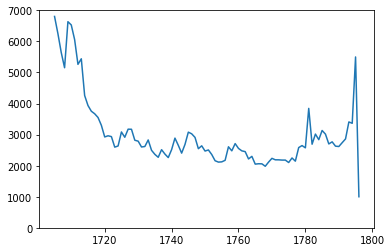

In [79]:
import matplotlib.pyplot as plt

query = make_aggs()
resolution_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

resolution_buckets = resolution_response['aggregations']['years']['buckets']
years = [bucket['key'] for bucket in sorted(resolution_buckets, key=lambda x: x['key'])]
resolution_counts = [bucket['doc_count'] for bucket in sorted(resolution_buckets, key=lambda x: x['key'])]


plt.plot(years, resolution_counts)
plt.ylim(0,7000)

#for bucket in sorted(buckets, key=lambda x: x['key']):
#    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/3324313160.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  missive_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


(0.0, 3500.0)

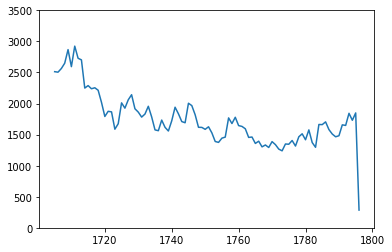

In [80]:
import matplotlib.pyplot as plt

query = make_prop_type_query('missive')
query['aggs'] = make_aggs()['aggs']
missive_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

missive_buckets = missive_response['aggregations']['years']['buckets']
years = [bucket['key'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]
missive_counts = [bucket['doc_count'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]


plt.plot(years, missive_counts)
plt.ylim(0,3500)

#for bucket in sorted(buckets, key=lambda x: x['key']):
#    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/4146967278.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  request_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


(0.0, 3500.0)

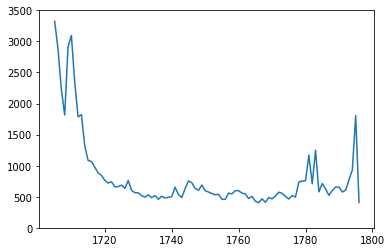

In [81]:
import matplotlib.pyplot as plt

query = make_prop_type_query('requeste')
query['aggs'] = make_aggs()['aggs']
request_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

request_buckets = request_response['aggregations']['years']['buckets']
years = [bucket['key'] for bucket in sorted(request_buckets, key=lambda x: x['key'])]
request_counts = [bucket['doc_count'] for bucket in sorted(request_buckets, key=lambda x: x['key'])]


plt.plot(years, request_counts)
plt.ylim(0,3500)

#for bucket in sorted(buckets, key=lambda x: x['key']):
#    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/1383413499.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  report_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


(0.0, 700.0)

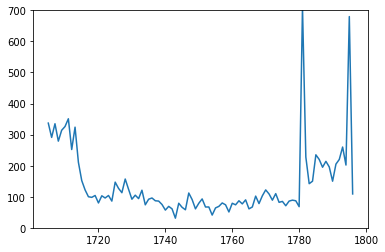

In [82]:
import matplotlib.pyplot as plt

query = make_prop_type_query('rapport')
query['aggs'] = make_aggs()['aggs']
report_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

report_buckets = report_response['aggregations']['years']['buckets']
years = [bucket['key'] for bucket in sorted(report_buckets, key=lambda x: x['key'])]
report_counts = [bucket['doc_count'] for bucket in sorted(report_buckets, key=lambda x: x['key'])]


plt.plot(years, report_counts)
plt.ylim(0,700)

#for bucket in sorted(buckets, key=lambda x: x['key']):
#    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

[1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796]
[6804, 6255, 5644, 5153, 6635, 6530, 6061, 5262, 5441, 4259, 3936, 3753, 3671, 3551, 3299, 2925, 2962, 2936, 2597, 2634, 3085, 2915, 3175, 3172, 2819, 2789, 2602, 2617, 2828, 2495, 2364, 2270, 2515, 2374, 2261, 2516, 2887, 2655, 2404, 2683, 3079, 3026, 2910, 2547, 2639, 2471, 2506, 2359, 2159, 2115, 2123, 2173, 2608, 2478, 2711, 2555, 2477, 2452, 2217, 2300, 2050, 2062, 2059, 1981, 2116, 2236, 2189, 2188, 2180, 2180, 2102, 2248, 2145, 2583, 26

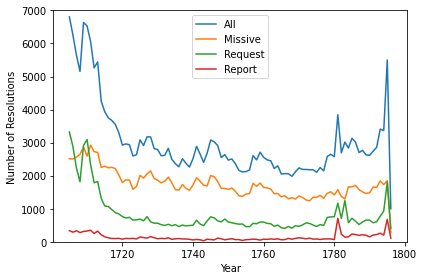

In [83]:
print(years)
print(resolution_counts)
plt.plot(years, resolution_counts, label='All')
plt.plot(years, missive_counts, label='Missive')
plt.plot(years, request_counts, label='Request')
plt.plot(years, report_counts, label='Report')
plt.ylim(0,7000)
plt.xlabel('Year')
plt.ylabel('Number of Resolutions')
plt.legend()

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'prop_type-period-year.png'
plt.tight_layout()
plt.savefig(fig_file)


1            23431
2            21546
3            25759
4            25097
5            26011
6            22878
7            24130
8            21900
9            21176
10           22667
11           21282
12           21424


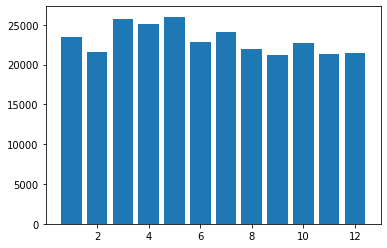

In [35]:

resolution_buckets = resolution_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(resolution_buckets, key=lambda x: x['key'])]
resolution_counts = [bucket['doc_count'] for bucket in sorted(resolution_buckets, key=lambda x: x['key'])]


plt.bar(months, resolution_counts)
#plt.ylim(0,3500)

for bucket in sorted(resolution_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

1            13213
2            11972
3            13653
4            13998
5            15277
6            13475
7            13872
8            13419
9            12691
10           13465
11           12765
12           13016


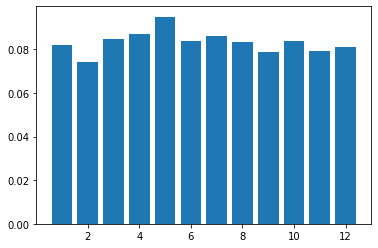

In [36]:

missive_buckets = missive_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]
missive_counts = [bucket['doc_count'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]
missive_sum_counts = sum(missive_counts)
missive_fracs = [missive_count / missive_sum_counts for missive_count in missive_counts]

plt.bar(months, missive_fracs)
#plt.ylim(0,3500)

for bucket in sorted(missive_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

1             6469
2             6358
3             8164
4             7281
5             6984
6             6331
7             6932
8             5470
9             5522
10            5750
11            5234
12            5139


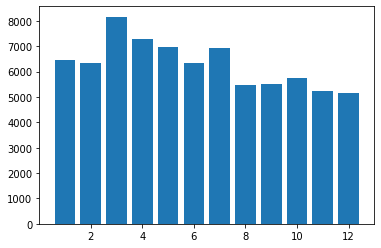

In [37]:
request_buckets = request_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(request_buckets, key=lambda x: x['key'])]
request_counts = [bucket['doc_count'] for bucket in sorted(request_buckets, key=lambda x: x['key'])]


plt.bar(months, request_counts)
#plt.ylim(0,3500)

for bucket in sorted(request_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

Lunae        67172
Martis       51770
Mercurii     37674
Jovis        41386
Veneris      55056
Sabbathi     24106
Dominica       137


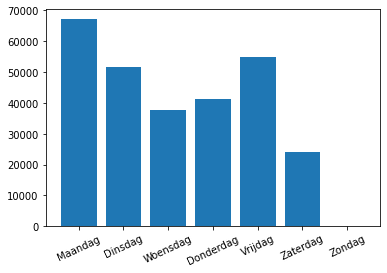

In [38]:
sorted_days = ['Lunae', 'Martis', 'Mercurii', 'Jovis', 'Veneris', 'Sabbathi', 'Dominica']
nl_labels = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
nl_short_labels = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
en_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

buckets = resolution_response['aggregations']['weekdays']['buckets']
weekdays = [bucket['key'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]
resolution_counts = [bucket['doc_count'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]

plt.bar(nl_labels, resolution_counts)
plt.xticks(rotation=25)

for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key'])):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")


Lunae        43366
Martis       30448
Mercurii     17682
Jovis        21200
Veneris      34094
Sabbathi     13932
Dominica        94


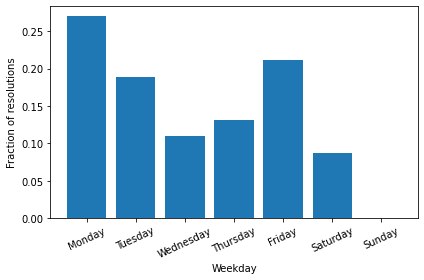

In [39]:
sorted_days = ['Lunae', 'Martis', 'Mercurii', 'Jovis', 'Veneris', 'Sabbathi', 'Dominica']
nl_labels = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
en_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

buckets = missive_response['aggregations']['weekdays']['buckets']
weekdays = [bucket['key'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]
missive_counts = [bucket['doc_count'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]
missive_sum_counts = sum(missive_counts)
missive_fracs = [missive_count / missive_sum_counts for missive_count in missive_counts]

plt.bar(en_labels, missive_fracs)
plt.xticks(rotation=25)
plt.ylabel('Fraction of resolutions')
plt.xlabel('Weekday')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'prop_type-missive-period-weekday.png'
plt.tight_layout()
plt.savefig(fig_file)

for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key'])):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")


Lunae        15009
Martis       14422
Mercurii     13865
Jovis        12949
Veneris      12317
Sabbathi      7056
Dominica        16


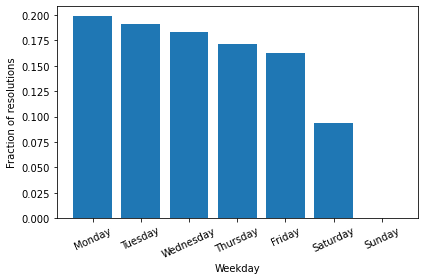

In [40]:
sorted_days = ['Lunae', 'Martis', 'Mercurii', 'Jovis', 'Veneris', 'Sabbathi', 'Dominica']
nl_labels = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
en_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

buckets = request_response['aggregations']['weekdays']['buckets']
weekdays = [bucket['key'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]
request_counts = [bucket['doc_count'] for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key']))]
request_sum_counts = sum(request_counts)
request_fracs = [request_count / request_sum_counts for request_count in request_counts]

plt.bar(en_labels, request_fracs)
plt.xticks(rotation=25)
plt.ylabel('Fraction of resolutions')
plt.xlabel('Weekday')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'prop_type-request-period-weekday.png'
plt.tight_layout()
plt.savefig(fig_file)

for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key'])):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")


Lunae        15009
Martis       14422
Mercurii     13865
Jovis        12949
Veneris      12317
Sabbathi      7056
Dominica        16
[0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85]
[1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15]


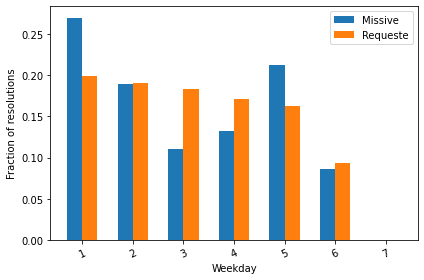

In [51]:
missive_idx = [i - 0.15 for i in range(1, 8)]
request_idx = [i + 0.15 for i in range(1, 8)]

plt.bar(missive_idx, missive_fracs, width=0.3, label='Missive')
plt.bar(request_idx, request_fracs, width=0.3, label='Requeste')
plt.xticks(rotation=25)
plt.ylabel('Fraction of resolutions')
plt.xlabel('Weekday')
plt.legend()

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'prop_type-period-weekday.png'
plt.tight_layout()
plt.savefig(fig_file)

for bucket in sorted(buckets, key=lambda x: sorted_days.index(x['key'])):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}")

print(missive_idx)
print(request_idx)


## Demonstrating the repetitiveness of resolutions

In [146]:
query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'paragraphs.text': 'Missive'}},
                {'match': {'paragraphs.text': 'Spina'}},
                #{'match': {'paragraphs.text': 'Franckfort'}},
            ]
        }
    }
}

response = es_republic.search(index='resolutions', body=query)

print(response['hits']['total'])


resolutions = [hit['_source'] for hit in response['hits']['hits']]

for resolution in resolutions:
    print(resolution['id'])
    print(resolution['paragraphs'][0]['text'])


{'value': 3257, 'relation': 'eq'}
session-1740-11-24-num-1-resolution-6
ONtfangen een Missive van den Resident Spina, geschreeven te Franckfort den twintighsten deeser loopende maand, houdende advertentie, en versoeckende om reedenen daar by geallegeert, dat haar Hoogh Mogende aan sijn Secretaris Bosch , de survivance gelieven te verleenen, om de Post als Resident te Franckfort, na het overlyden van hem Resident Spina te bekleeden. WAAR op gedelibereert zynde, is goedgevonden en verstaan, dat aan gemelden Resident de Spina zal werden gerescribeert, dat het verleenen van survivances strydigh is met de Ordres en Resolutien van den Lande, en dat derhalven in het voorschreeve versoeck niet kan werden getreeden.
session-1720-04-15-num-1-resolution-3
ONtfangen een Missive van den Resident Spina, geschreven te Heydelbergh den negenden deser loopende maandt, ende daar nevens eenige Bylagen , houdende advertentie , ende versoeckende nochmaal een keer naar Franckfort te mogen doen. WAAR op gedel

In [41]:
query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'metadata.proposition_type.keyword': 'missive'}},
                {
                    'bool': {
                        'should': [
                            {'match': {'metadata.proposition_origin.full_string.text': 'Spina'}},
                            {'match': {'metadata.proposer.full_string.text': 'Spina'}},
                        ]
                    }
                }
                #{'match': {'paragraphs.text': 'Franckfort'}},
            ],
        }
    }
}

response = rep_es.es_anno.search(index='resolution_metadata', body=query)

resolutions = [hit['_source'] for hit in response['hits']['hits']]

print(response['hits']['total'])



{'value': 3303, 'relation': 'eq'}


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/763391174.py:20: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = rep_es.es_anno.search(index='resolution_metadata', body=query)


#### Searching multiple keywords across pages and across resolutions

In [156]:
query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'paragraphs.text': 'Reeckenkamer'}},
                {'match': {'paragraphs.text': 'koopluyden'}},
                #{'match': {'paragraphs.text': 'Franckfort'}},
            ]
        }
    }
}

response = es_republic.search(index='resolutions', body=query)

print(response['hits']['total'])


resolutions = [hit['_source'] for hit in response['hits']['hits']]

for resolution in resolutions:
    print(resolution['id'])
    for paragraph in resolution['paragraphs']:
        print('\t', paragraph['text'])
        print(paragraph['line_ranges'][0]['line_id'])
    print()


{'value': 22, 'relation': 'eq'}
session-1714-09-06-num-1-resolution-5
	 IS ter Vergaderinge gelesen de Requeste van Arnold Costerius, Licentiaet in de Rechten , Scholtis ende Rentmeester der Stadt ende Heerlijckheydt Weerdt, houden de, in gevolge ende tot voldoeninge van haer Hoogh Mogende Resolutie van den negenden laetslleden, des selfs beright op de Requeste van Henricus Theodorus Bistervelt, Pastoor tot Weert, versoeckende hy Suppliant, om redenen in de voorschreve Requeste geallegeert, dat haer Hoogh Mogende het Hof van het Overquartier van Gelderlandt gelieven aen te schryven, sigh punctuelijck te reguleren naer de Reglementen, Instructien ende Resolutien, by de voorschreve Xequeste breder gemelt, met belastinge aen den Pastoor Bistervelt, van te laten varen de persoonele actien die hy tegens hem Suppliant privato nomine voor het voorsz Hof hadde geinstitucert, en den selven geheel in te stellen voor des selfs domiciliairen Rechter. WAER op gedelibereert zynde, is goetgevonden en

In [154]:
query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'columns.lines.text': 'Reeckenkamer'}},
                {'match': {'columns.lines.text': 'koopluyden'}},
                #{'match': {'paragraphs.text': 'Franckfort'}},
            ]
        }
    }
}

response = es_republic.search(index='pages', body=query)

print(response['hits']['total'])


pages = [hit['_source'] for hit in response['hits']['hits']]

for page in pages:
    print(page['id'])
    for column in page['columns']:
        for line in column['lines']:
            print('\t', line['text'])
    print()


{'value': 116, 'relation': 'eq'}
NL-HaNA_1.01.02_3780_0087-page-172
	 resteert zyn de Depesches daar uyt resulte-
	 rende.
	 ONtfangen een Missive van den Com-
	 missaris van Bleyswyck , geschreven te
	 Dantzigh den vier en twintighsten der
	 voorlede maandt , houdende advertentie.
	 WAAR op geen resolutie is gevallen.
	 taris Rumpf, geschreven te Berlijn den
	 ONtfangen een Missive van den Secre-
	 seven en twintighsten der voorlede
	 maandt, houdende advertentie. WAAR
	 op geen resolutie is gevallen.
	 vander Meer, haar Hoogh Mogende-
	 ONtfangen een Missive van den Heere
	 Ambassadeur aan het Hof van sijne
	 Majesteyt den Koningh van Spaigne , ge-
	 schreven te Madrid den vyftienden der voorlede
	 maandt, houdende advertentie. WAAR
	 op geen resolutie is gevallen.
	 ris van den Heere Hop, haar Hoogh
	 ONtfangen een Missive van den Secreta-
	 Mogende Ambassadeur aan het Hof
	 van sijne Majesteyt den Koninggh van
	 Vranckryck, geschreven te Parys den ne-
	 gen en twintighsten der voor

	 Jullens.
	 men, zyn gelesen en geresumeert,
	 DE Resolutien gisteren geno-
	 gelyck oock geresumeert en gear-
	 resteert zyn de Depesches daar uyt resul-
	 teerende.
	 dent van Assendelfi, geschreven te
	 ONtfangen een Missive van den Resi-
	 Brussel den tweeden deser loopende
	 maandt , houdende , dat hy by sijne Missi-
	 ve van den negen en twintighsten April
	 laatstleden, aan haar Hoogh Mogende had-
	 de bericht, dat de Aartz-Hertoginne geor-
	 donneert hadde het proces tusschen de
	 Zeeuwsche Koopluyden en de Commisen
	 van sijne Majesteyts rechten te St. Philip-
	 pe, wegens de aangehaalde tonnen Muylen,
	 ten eersten op het tapyt te brengen , doch
	 dat de Rechters geen Sententie zouden pro-
	 nuncieeren, alvoorens de zelve aan haare-
	 Hoogheydt te hebben gecommuniceert, het
	 geen eyndelijck was geschiedt, hebbende
	 de drie Rechters van de zoogenaamde Su-
	 prema-Kamer, bestaande in een Raadtsheer
	 uyt den Raadt van Finantie, ende twee
	 Raadtsheeren uyt den Raadt van Brab

## Analysing Person Roles and Propositions

In [42]:
def make_person_role_query(prop_type, size=0):
    if isinstance(prop_type, list):
        match_list = [{'match': {'metadata.proposer.person_role.text': pt}} for pt in prop_type]
    else:
        match_list = [{'match': {'metadata.proposer.person_role.text': prop_type}}]
    return {
        'query': {
            'bool': {
                'should': match_list
            }
        },
        'size': size,
        'track_total_hits': True,
        'aggs': {
            'years': {
                'terms': {
                    'field': 'metadata.session_year',
                    'size': 100
                }
            },
            'months': {
                'terms': {
                    'field': 'metadata.session_month',
                    'size': 12
                }
            },
            'weekdays': {
                'terms': {
                    'field': 'metadata.session_weekday.keyword',
                }
            },
            'prop_types': {
                'terms': {
                    'field': 'metadata.proposition_type.keyword',
                }
            }
        }
    }




In [43]:
query = make_person_role_query(['Kinderen'])

env_response = rep_es.es_anno.search(index='resolution_metadata', 
                                     query=query["query"], aggs=query["aggs"],
                                     size = 10, track_total_hits=True)

env_type_buckets = env_response['aggregations']['prop_types']['buckets']
num_buckets = env_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(env_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


9007
rapport       7460	0.83
missive        663	0.07
unknown        460	0.05
requeste       141	0.02
oral            99	0.01
memorie         81	0.01
declaratie      58	0.01
resolution      15	0.00
conclusie       13	0.00
document        13	0.00


In [42]:
res_mets = [hit['_source'] for hit in env_response['hits']['hits']]
for res_met in res_mets:
    if res_met["metadata"]["proposition_type"] == "rapport":
        res_id = res_met["metadata"]["id"][:-9]
        res = rep_es.retrieve_resolution_by_id(res_id)
        print(res.paragraphs[0].text)

IS gehoort het rapport van de Heeren van Hoytema, en andere haar Hoog Mogende Ge seputeerden tot de saacken van het Overquartier van Gelderland, hebbende in gevolge en ter voldoeninge van haar Hoogh Mogende Resolutie commissoriaal van den aght en twintighsten April laatstleeden, met en beneevens eenige Heeren Gecommitteerden uyt den Raad van Staate, geëxamineert een Missive van C. vanden Broeck en Joh. Franc. vanden Broeck, Raad en Momboir van den Hove, geordonneert in het Overquartier van Gelderland, geschreeven te Venlo den vyf en twintighsten bevoorens; hou sende, dat nietjeegenstaan le hunne aangewende devoiren, aangaande de verschillen over de finaale afpaalingh van den Aldeneyk en Roosteren, als het vereffenen van die van Magzeyck en Roosteren, en den Ophovenschen Dyck, oft Dyck by Geystingen, reght over Steevenswaard geleegen, nietwes had kunnen werden verright, hebbende de Onderdanen van Ophoven, Luycks Territoir, sigh niet alleen niet ontsien de gemelde Ophovensche Dyck, in de

In [91]:
query = make_person_role_query(['Envoyé', 'Ambassadeur'])

env_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

env_type_buckets = env_response['aggregations']['prop_types']['buckets']
num_buckets = env_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(env_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


44623
missive      39041	0.87
memorie       2227	0.05
requeste      1477	0.03
oral          1298	0.03
unknown        282	0.01
resolution     107	0.00
declaratie      97	0.00
rapport         50	0.00
presentatie     28	0.00
document         6	0.00


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/4154874671.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  env_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


[40.95652173913044, 37.01086956521739, 40.08695652173913, 40.65217391304348, 42.23913043478261, 39.33695652173913, 43.40217391304348, 43.358695652173914, 40.01086956521739, 40.32608695652174, 38.48913043478261, 39.16304347826087]


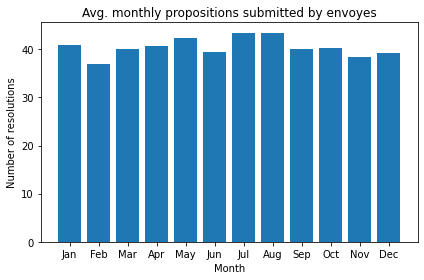

In [92]:
env_month_buckets = env_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(env_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(env_month_buckets, key=lambda x: x['key'])]

fig, ax = plt.subplots()

plt.bar(months, counts)
print(counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0) 
plt.title('Avg. monthly propositions submitted by envoyes')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-envoye-period-month.png'
plt.tight_layout()
plt.savefig(fig_file)


In [93]:
query = make_person_role_query('Ambassadeur')

amb_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

amb_type_buckets = amb_response['aggregations']['prop_types']['buckets']
num_buckets = amb_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(amb_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


12500
missive      10844	0.87
requeste       541	0.04
memorie        446	0.04
oral           443	0.04
unknown        104	0.01
resolution      40	0.00
declaratie      39	0.00
rapport         23	0.00
presentatie     14	0.00
document         3	0.00


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/3496511828.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  amb_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


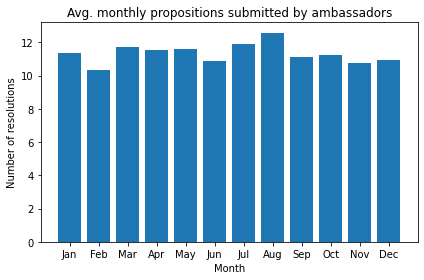

In [94]:
amb_month_buckets = amb_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(amb_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(amb_month_buckets, key=lambda x: x['key'])]

fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0) 
plt.title('Avg. monthly propositions submitted by ambassadors')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-ambassadors-period-month.png'
plt.tight_layout()
plt.savefig(fig_file)


In [54]:
query = make_person_role_query('Ambassadeur')
query['query']['bool']['must'] = [
    {'match': {'metadata.proposition_type': 'requeste'}},
    {'match': {'metadata.proposer.person_role.text': 'Ambassadeur'}}
]

del query['query']['bool']['should']

amb_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

amb_type_buckets = amb_response['aggregations']['prop_types']['buckets']
num_buckets = amb_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(amb_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


541
requeste       541	1.00


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/3479166281.py:9: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  amb_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


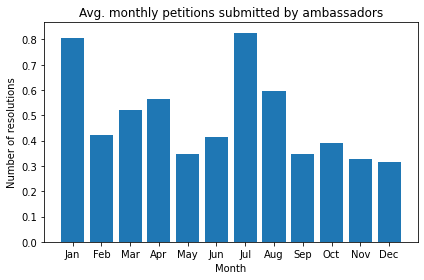

In [89]:
amb_month_buckets = amb_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(amb_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(amb_month_buckets, key=lambda x: x['key'])]

fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0) 
plt.title('Avg. monthly petitions submitted by ambassadors')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-ambassadors-period-month-requests.png'
plt.tight_layout()
plt.savefig(fig_file)


In [87]:
query = make_person_role_query('Metselaar')

brick_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

brick_type_buckets = brick_response['aggregations']['prop_types']['buckets']
num_buckets = brick_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(brick_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


152
requeste       102	0.67
rekening        27	0.18
declaratie      16	0.11
missive          4	0.03
conclusie        1	0.01
rapport          1	0.01
unknown          1	0.01


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/1585328446.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  brick_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


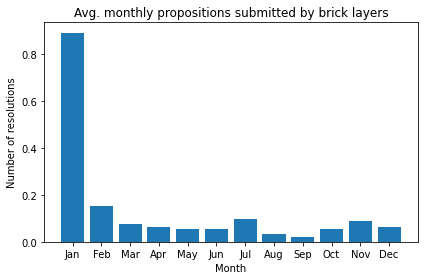

In [88]:
brick_month_buckets = brick_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(brick_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(brick_month_buckets, key=lambda x: x['key'])]


fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0)
plt.title('Avg. monthly propositions submitted by brick layers')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-bricklayers-period-month.png'
plt.tight_layout()
plt.savefig(fig_file)



In [60]:
query = make_person_role_query('Metselaar')
query['query']['bool']['must'] = [
    {'match': {'metadata.proposition_type': 'requeste'}},
    {'match': {'metadata.proposer.person_role.text': 'Metselaar'}}
]

brick_response = rep_es.es_anno.search(index='resolution_metadata', body=query)

brick_type_buckets = brick_response['aggregations']['prop_types']['buckets']
num_buckets = brick_response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(brick_type_buckets, key=lambda x: x['doc_count'], reverse=True):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")



102
requeste       102	1.00


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/3793677442.py:7: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  brick_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


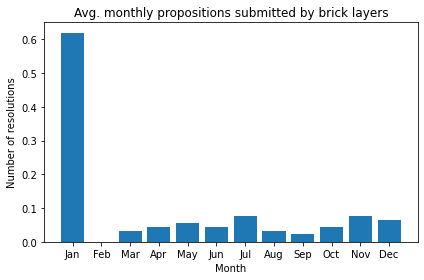

In [85]:
brick_month_buckets = brick_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(brick_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(brick_month_buckets, key=lambda x: x['key'])]


fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0)
plt.title('Avg. monthly propositions submitted by brick layers')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-bricklayers-period-month-requests.png'
plt.tight_layout()
plt.savefig(fig_file)



In [95]:
query = make_person_role_query(['Burger', 'Borger', 'Burgers', 'Borgers'])

cit_response = rep_es.es_anno.search(index='resolution_metadata', body=query)
response

cit_type_buckets = cit_response['aggregations']['prop_types']['buckets']
num_buckets = response['hits']['total']['value']
num_buckets = sum([bucket['doc_count'] for bucket in cit_type_buckets])
print(num_buckets)
for bucket in sorted(cit_type_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/271342641.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  cit_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


3091
advies           8	0.00
conclusie       21	0.01
memorie         13	0.00
missive         61	0.02
oral            81	0.03
presentatie      7	0.00
rapport        138	0.04
requeste      2696	0.87
resolution      17	0.01
unknown         49	0.02


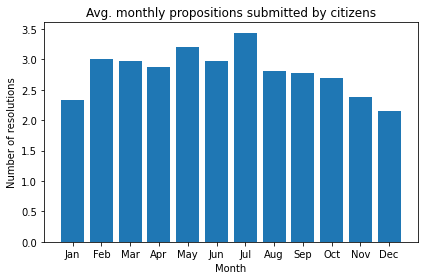

In [97]:
cit_month_buckets = cit_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(cit_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(cit_month_buckets, key=lambda x: x['key'])]


fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0)
plt.title('Avg. monthly propositions submitted by citizens')
plt.ylabel('Number of resolutions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-citizens-period-month.png'
plt.tight_layout()
plt.savefig(fig_file)



In [63]:
query = make_person_role_query(['Koopman', 'Koopvrouw', 'Kooplieden'])

merch_response = rep_es.es_anno.search(index='resolution_metadata', body=query)
response

merch_type_buckets = merch_response['aggregations']['prop_types']['buckets']
num_buckets = response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(merch_type_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


3303
advies          16	0.00
conclusie      370	0.11
differente       8	0.00
memorie         33	0.01
missive         63	0.02
oral            81	0.02
rapport          3	0.00
requeste     10299	3.12
resolution      25	0.01
unknown        217	0.07


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/909386052.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  merch_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


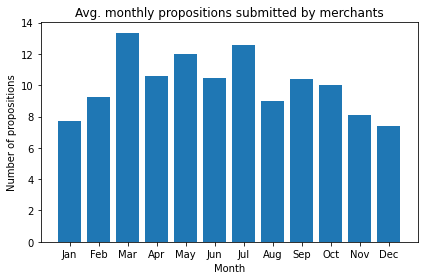

In [64]:
merch_month_buckets = merch_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]


fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0)
plt.title('Avg. monthly propositions submitted by merchants')
plt.ylabel('Number of propositions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-merchants-period-month.png'
plt.tight_layout()
plt.savefig(fig_file)



In [68]:
query = make_person_role_query(['Koopman', 'Koopvrouw', 'Kooplieden'])
del query['query']['bool']['should']
query['query']['bool']['should'] = [
    {
        'bool': {
                'must': [
                    {'match': {'metadata.proposition_type': 'requeste'}},
                    {'match': {'metadata.proposer.person_role.text': 'Koopman'}}                
                ]
        }
    },
    {
        'bool': {
                'must': [
                    {'match': {'metadata.proposition_type': 'requeste'}},
                    {'match': {'metadata.proposer.person_role.text': 'Koopvrouw'}}                
                ]
        }
    },
    {
        'bool': {
                'must': [
                    {'match': {'metadata.proposition_type': 'requeste'}},
                    {'match': {'metadata.proposer.person_role.text': 'Kooplieden'}}                
                ]
        }
    }
]

query['track_total_hits'] = True


merch_response = rep_es.es_anno.search(index='resolution_metadata', body=query)
response

merch_type_buckets = merch_response['aggregations']['prop_types']['buckets']
num_buckets = response['hits']['total']['value']
print(num_buckets)
for bucket in sorted(merch_type_buckets, key=lambda x: x['key']):
    print(f"{bucket['key']: <12}{bucket['doc_count']: >6}\t{bucket['doc_count'] / num_buckets: >.2f}")


3303
requeste     10299	3.12


/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_76816/618931235.py:33: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  merch_response = rep_es.es_anno.search(index='resolution_metadata', body=query)


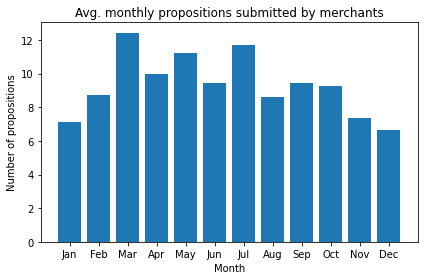

In [69]:
merch_month_buckets = merch_response['aggregations']['months']['buckets']

months = [bucket['key'] for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]
counts = [bucket['doc_count'] / 92 for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]


fig, ax = plt.subplots()

plt.bar(months, counts)
ax.set_xticks([i for i in range(1,13)])
xlabels = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]
ax.set_xticklabels(xlabels, rotation=0)
plt.title('Avg. monthly propositions submitted by merchants')
plt.ylabel('Number of propositions')
plt.xlabel('Month')

fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
fig_file = fig_dir + 'person_role-merchants-period-month-requests.png'
plt.tight_layout()
plt.savefig(fig_file)



<AxesSubplot:xlabel='Month'>

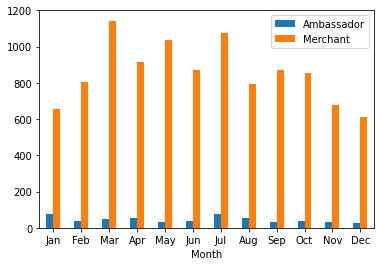

In [73]:
import pandas as pd


amb_counts = [bucket['doc_count'] for bucket in sorted(amb_month_buckets, key=lambda x: x['key'])]
merch_counts = [bucket['doc_count'] for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]
months = [bucket['key'] for bucket in sorted(merch_month_buckets, key=lambda x: x['key'])]

months = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]

df = pd.DataFrame(data={'Month': months, 'Ambassador': amb_counts, 'Merchant': merch_counts})

df = df.set_index('Month')
#fig, ax = plt.subplots()

#plt.bar(months, counts)
#ax.set_xticks([i for i in range(1,13)])
#ax.set_xticklabels(xlabels, rotation=45)
#plt.title('Propositions submitted by merchants')
#plt.ylabel('Number of resolutions')
#plt.xlabel('Month')

#fig_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Projects/REPUBLIC/Symposium-afscheid-Ida/'
#fig_file = fig_dir + 'person_role-kooplieden-period-month.png'
#plt.tight_layout()
#plt.savefig(fig_file)
df.plot(kind='bar', rot=0)


## Combining proposition dimensions

In [168]:
def make_aggregation(field, size=100):
    return {
        'terms': {'field': field, 'size': size}
    }

def make_agg_data_frame(buckets, label):
    data = {
        label: [bucket['key'] for bucket in buckets],
        'count': [bucket['doc_count'] for bucket in buckets]
    }
    df = pd.DataFrame(data=data)
    return df.set_index(label)

def make_proposition_location_query(location, size=10):
    return {
        'query': {
            'bool': {
                'must': [
                    {'match': {'metadata.proposer.location.text.keyword': location}}
                ]
            }
        },
        'size': size,
        'track_total_hits': True
    }

def add_agg_fields(query):
    query['aggs'] = make_aggs()['aggs']
    for agg_name in field:
        query['aggs'][agg_name] = make_aggregation(field[agg_name])
    return query

location = 'Amsterdam'
location = 'Groot Britannien'

field = {
    'locations': 'metadata.proposer.location.text.keyword',
    'person_roles': 'metadata.proposer.person_role.text.keyword',
    'proposition_types': 'metadata.proposition_type.keyword'
}

query = make_proposition_location_query(location, size=0)
uk_query = add_agg_fields(query)

uk_response = es_republic.search(index='resolution_metadata', body=uk_query)
#uk_weekday_buckets = uk_response['aggregations']['weekdays']['buckets']
#make_agg_data_frame(uk_weekday_buckets, 'weekday').plot(kind='bar')


total = uk_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in uk_response['aggregations']['person_roles']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")

Total                         	   10051
----------------------------------------
extraordinaris                	    8623
Envoyé                        	    8246
den Koning van                	    6747
Plenipotentiaris              	    3058
Ambassadeur                   	     670
sijne Majesteit               	     576
Minister                      	     369
de Kinderen van               	     259
Gedeputeerde                  	     187
Commissaris van               	      43
Regent                        	      43
Scheepenen                    	      36
Gecommitteerden uit           	      30
Suppliant                     	      19
den Grave van                 	      16
Lieutenant                    	      13
Impetrant                     	      12
Schipper                      	       9
Generaal Major                	       8
Consul van                    	       6
Geinteresseerden in           	       5
de Erfgenaamen van            	       5
Kooplieden                    	       4

In [169]:
location = 'Amsterdam'

query = make_proposition_location_query(location, size=0)
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['person_roles']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")

Total                         	    9209
----------------------------------------
Koopman                       	    2678
Kooplieden                    	    2309
Schipper                      	     841
Burger                        	     737
Inwoonder                     	     407
Boekhouder                    	     303
Suppliant                     	     245
sijne Hoogheid                	     189
den Representant van          	     188
Scheepenen                    	     184
Gecommitteerden uit           	     178
Burgemeester                  	     127
Weduwe                        	     106
Impetrant                     	     100
Gedeputeerde                  	      81
Geinteresseerden in           	      75
Regent                        	      57
Capitein ter Zee              	      53
Commissaris van               	      45
extraordinaris                	      45
den Koning van                	      43
Envoyé                        	      41
Advocaaten van                	      38

In [170]:
location = 'Amsterdam'

query = make_proposition_location_query(location, size=0)
ams_query = add_agg_fields(query)

print(ams_query)


ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['proposition_types']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")


{'query': {'bool': {'must': [{'match': {'metadata.proposer.location.text.keyword': 'Amsterdam'}}]}}, 'size': 0, 'track_total_hits': True, 'aggs': {'prop_type': {'terms': {'field': 'metadata.proposition_type.keyword', 'size': 20}}, 'years': {'terms': {'field': 'metadata.session_year', 'size': 100}}, 'months': {'terms': {'field': 'metadata.session_month', 'size': 12}}, 'weekdays': {'terms': {'field': 'metadata.session_weekday.keyword'}}, 'locations': {'terms': {'field': 'metadata.proposer.location.text.keyword', 'size': 100}}, 'person_roles': {'terms': {'field': 'metadata.proposer.person_role.text.keyword', 'size': 100}}, 'proposition_types': {'terms': {'field': 'metadata.proposition_type.keyword', 'size': 100}}}}
Total                         	    9209
----------------------------------------
requeste                      	    5918
missive                       	    2523
conclusie                     	     268
unknown                       	     166
oral                          	     1

In [172]:
query = make_person_role_query(['Koopman', 'Koopvrouw', 'Kooplieden'])
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['locations']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")

Total                         	   11119
----------------------------------------
Amsterdam                     	    4902
Rotterdam                     	    1551
Dordrecht                     	     398
Londen                        	     342
Middelburg                    	     325
Leyden                        	     218
Brussel                       	     206
Maastricht                    	     129
Lissabon                      	     119
Weenen                        	     108
's Hertogenbosch              	      82
Utrecht                       	      80
Keulen                        	      57
Venlo                         	      49
Harlingen                     	      36
Groningen                     	      33
Dantzig                       	      22
Livorno                       	      22
Vranckrijk                    	      22
Arnhem                        	      21
Hamburg                       	      21
Barcelona                     	      20
Parys                         	      18

In [174]:
query = make_person_role_query('Ambassadeur')
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['locations']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")

Total                         	   12500
----------------------------------------
Groot Britannien              	     670
Vranckrijk                    	     621
Parys                         	      48
Madrid                        	      38
Amsterdam                     	      29
Weenen                        	      21
Londen                        	      20
Dresden                       	      18
St. Petersburg                	      16
Utrecht                       	      12
Hamburg                       	      11
Pruissen                      	      10
Rotterdam                     	       9
Keulen                        	       7
Brussel                       	       6
Maastricht                    	       6
Dantzig                       	       4
Livorno                       	       4
Stad en Lande                 	       4
Arnhem                        	       2
Barcelona                     	       2
Koppenhagen                   	       2
Leyden                        	       2

In [176]:
query = make_person_role_query('Envoyé')
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['locations']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")


Total                         	   32258
----------------------------------------
Groot Britannien              	    8246
Pruissen                      	    4197
Londen                        	     545
Weenen                        	     359
Groningen                     	     210
Berlyn                        	     112
Munster                       	      78
Keulen                        	      72
Stockholm                     	      47
Amsterdam                     	      41
Dresden                       	      39
Hamburg                       	      38
Koppenhagen                   	      30
Leyden                        	      27
St. Petersburg                	      21
Brussel                       	      15
Maastricht                    	      13
Turin                         	      13
Utrecht                       	      12
Venlo                         	      12
Madrid                        	      11
Dantzig                       	       8
de Oostentycksche Nederlanden 	       7

In [178]:
query['query']['bool']['must'] = {'match': {'metadata.proposition_type.keyword': 'missive'}}
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['locations']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")


Total                         	  160816
----------------------------------------
Groot Britannien              	    8559
Pruissen                      	    5100
Amsterdam                     	    2523
de Oostentycksche Nederlanden 	    2210
Brussel                       	    1849
Maastricht                    	    1676
Keulen                        	    1473
Londen                        	    1097
's Hertogenbosch              	    1053
Stad en Lande                 	    1043
Venlo                         	     974
Utrecht                       	     597
Vranckrijk                    	     531
Weenen                        	     498
Dresden                       	     473
Groningen                     	     416
Weftvriesland en den Noorder Quartiere	     377
Leyden                        	     307
Regensburgh                   	     246
Munster                       	     191
Rotterdam                     	     171
Hamburg                       	     158
Parys                         	

In [180]:
query['query']['bool']['must'] = {'match': {'metadata.proposition_type.keyword': 'requeste'}}
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['locations']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")



Total                         	   75634
----------------------------------------
Amsterdam                     	    5918
's Hertogenbosch              	    4920
Londen                        	    3002
Maastricht                    	    2275
Rotterdam                     	    1800
Leyden                        	     919
Venlo                         	     809
Weenen                        	     690
Brussel                       	     667
Middelburg                    	     616
Dordrecht                     	     555
Vranckrijk                    	     485
Groot Britannien              	     442
Keulen                        	     323
Utrecht                       	     323
Pruissen                      	     284
Algiers                       	     259
Groningen                     	     208
Stad en Lande                 	     162
Lissabon                      	     161
Hamburg                       	     159
Eyndhoven                     	     120
Livorno                       	     100

In [194]:
import json

query['query']['bool']['must'] = [
    {'match': {'metadata.proposition_type.keyword': 'missive'}},
    {'match': {'metadata.proposer.location.text.keyword': 'Amsterdam'}}
]
query['size'] = 10
ams_query = add_agg_fields(query)

ams_response = es_republic.search(index='resolution_metadata', body=ams_query)


total = ams_response['hits']['total']['value']
print(f"{'Total': <30}\t{total: >8}")
print('----------------------------------------')
for bucket in ams_response['aggregations']['person_roles']['buckets']:
    print(f"{bucket['key']: <30}\t{bucket['doc_count']: >8}")

for hit in ams_response['hits']['hits']:
    doc = hit['_source']
    print(doc['metadata']['id'])
    print(json.dumps(doc['metadata']['proposer']['full_string'], indent=4))
    print()

Total                         	    2523
----------------------------------------
sijne Hoogheid                	     176
den Representant van          	     175
Gecommitteerden uit           	      28
Advocaaten van                	      26
Burgemeester                  	      22
Scheepenen                    	      12
Envoyé                        	      10
Kooplieden                    	      10
Schipper                      	       9
extraordinaris                	       8
Koopman                       	       7
Gedeputeerde                  	       5
Minister                      	       5
den Commissaris Generaal      	       5
Commissaris van               	       4
den Koning van                	       4
Comptoir van                  	       3
Consul van                    	       3
Lieutenant                    	       3
Ambassadeur                   	       2
Boekhouder                    	       2
Generaal Major                	       2
Magistraat                    	       2

In [197]:
pm_index = 'phrase_matches'

query = {
    'query': {
        'bool': {
            'must': [
                {'match': {'label': 'person_role'}}
            ]
        }
    },
    'size': 0,
    'track_total_hits': True,
    'aggs': {
        'person_roles': {
            'terms': {'field': 'phrase.keyword', 'size': 200}
        }
    }
}

es_republic.search(index=pm_index, body=query)

{'took': 93,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1329027, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'person_roles': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Suppliant', 'doc_count': 252189},
    {'key': 'Gedeputeerde', 'doc_count': 135497},
    {'key': 'extraordinaris', 'doc_count': 63756},
    {'key': 'Gecommitteerden uit', 'doc_count': 59270},
    {'key': 'Scheepenen', 'doc_count': 54889},
    {'key': 'Regent', 'doc_count': 54363},
    {'key': 'sijne Majesteit', 'doc_count': 53859},
    {'key': 'den Koning van', 'doc_count': 48231},
    {'key': 'Envoyé', 'doc_count': 47113},
    {'key': 'de Kinderen van ', 'doc_count': 44984},
    {'key': 'Minister', 'doc_count': 41267},
    {'key': 'den Griffier', 'doc_count': 39186},
    {'key': 'ter Vergaderinge praesideerende', 'doc_count': 35267},
    {'key': 'den Resident', 'doc_count'

## Analysing propositions without a known person role

In [264]:
import json

def get_full_string_start_end(doc, element_name):
    if 'metadata' not in doc or element_name not in doc['metadata']:
        return None, None
    if doc['metadata'][element_name] is None:
        return None, None
        for field in prop_fields:
            print(field, doc['metadata'][field])
    fs = doc['metadata'][element_name]['full_string']
    return fs['start_offset'], fs['end_offset']

query = {
    'query': {
        'bool': {
            'must_not': {
                'exists': {'field': 'metadata.proposer.person_role.text'}
            }
        }
    }
}

prop_fields = ['proposer', 'formula', 'proposition_origin']

response = es_republic.search(index='resolution_metadata', body=query)

docs = [hit['_source'] for hit in response['hits']['hits']]
for doc in docs:
    res_id = doc['metadata']['id'].replace('-metadata','')
    formula_start, formula_end = get_full_string_start_end(doc, 'formula')
    proposer_start, proposer_end = get_full_string_start_end(doc, 'proposer')
    print(res_id, formula_start, formula_end, '\t', proposer_start, proposer_end)
    if proposer_start is None or proposer_start > formula_end + 5:
        for field in prop_fields:
            print(json.dumps(doc['metadata'][field], indent=2))
        resolution = rep_es.retrieve_resolution_by_id(es_republic, res_id, inv_config)
        print(resolution.paragraphs[0].text)
    

session-1737-05-06-num-1-resolution-15 0 25 	 22 92
session-1778-07-24-num-1-resolution-4 0 25 	 26 66
session-1757-07-13-num-1-resolution-5 0 46 	 46 69
session-1778-07-24-num-1-resolution-5 0 25 	 26 65
session-1757-07-13-num-1-resolution-6 0 45 	 45 125
session-1711-10-26-num-1-resolution-2 0 25 	 25 116
session-1757-07-15-num-1-resolution-3 0 25 	 None None
null
{
  "proposition_opening": {
    "text": "ONtfangen een Missive van",
    "start_offset": 0,
    "end_offset": 25
  },
  "full_string": {
    "text": "ONtfangen een Missive van",
    "start_offset": 0,
    "end_offset": 25
  }
}
{
  "variable_entity": {
    "text": "den Agent Palairet,",
    "start_offset": 25,
    "end_offset": 44
  },
  "correspondence_from": {
    "text": "geschreeven te",
    "start_offset": 46,
    "end_offset": 60
  },
  "location": {
    "text": "Londen",
    "start_offset": 61,
    "end_offset": 67
  },
  "temporal_reference": {
    "text": "den 1 deeser loopende maand",
    "start_offset": 68,
    